<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

***

In [1]:
import os

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from sklearn.metrics import mean_absolute_error as mae

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# sns.set_style('dark')

In [2]:
# !pip install missingno

In [3]:
import missingno as msno

## Подготовка данных

In [4]:
def get_data(filename):
    
    """
    Reads the data from the given path.
    """

    pth1 = f'/datasets/{filename}'
    pth2 = f'data/{filename}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, index_col='date', parse_dates=True)
        print(f'Reading {pth1}...')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, index_col='date', parse_dates=True)
        print(f'Reading {pth2}...')
    else:
        print('Check the file path')

    return df

In [5]:
full_df = get_data('gold_recovery_full_new.csv')
test_df = get_data('gold_recovery_test_new.csv')
train_df = get_data('gold_recovery_train_new.csv')

Reading data/gold_recovery_full_new.csv...
Reading data/gold_recovery_test_new.csv...
Reading data/gold_recovery_train_new.csv...


### Проверка рассчета эффективности обогощения

### $\text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)}$

In [6]:
C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

recovery = (C * (F - T)) / (F * (C - T)) * 100

In [7]:
train_recovery_mae = mae(recovery, train_df['rougher.output.recovery'])

print(f'rougher.output.recovery check: MAE = {train_recovery_mae:.2e}')

if train_recovery_mae < 1e-5:
    print('rougher.output.recovery check: PASSED')

rougher.output.recovery check: MAE = 9.74e-15
rougher.output.recovery check: PASSED


> Эффективность обогощения рассчитана корректно

### Состав признаков

In [8]:
train_minus_test_cols = set(train_df.columns) - set(test_df.columns)

train_df[train_minus_test_cols].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.output.concentrate_au                       14149 non-null  float64
 1   primary_cleaner.output.concentrate_ag               14149 non-null  float64
 2   secondary_cleaner.output.tail_au                    14149 non-null  float64
 3   primary_cleaner.output.tail_ag                      14148 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.tail_au                                14149 non-null  float64
 6   rougher.output.concentrate_ag                       14149 non-null  float64
 7   primary_cleaner.output.concentrate_au               14149 non-null  float64
 8   rougher.calculation.sulfate_to_au_concent

/var/folders/nc/53ydtkz56jj83586jxv6mvlm0000gn/T/ipykernel_58586/84675947.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df[train_minus_test_cols].info()


In [9]:
types = []

for col in train_minus_test_cols:
    
    parameter_type = col.split('.')[1]
    if parameter_type not in types:
        types.append(parameter_type)

print(f'Feature types not in the test dataset: {types}')

Feature types not in the test dataset: ['output', 'calculation']


In [10]:
print(f'Number of features in the train dataset: {len(train_df.columns)}')
train_df = train_df.drop(columns=train_minus_test_cols)
print(f'Number of features in the train dataset: {len(train_df.columns)}')

Number of features in the train dataset: 86
Number of features in the train dataset: 52


> В тестовом датасете отсутствуют некоторые расчетные характеристики и параметры продукта


> Из тренировочного датасета были исключены колонки, отсутствующие в тестовой выборке

### Заполнение пропусков

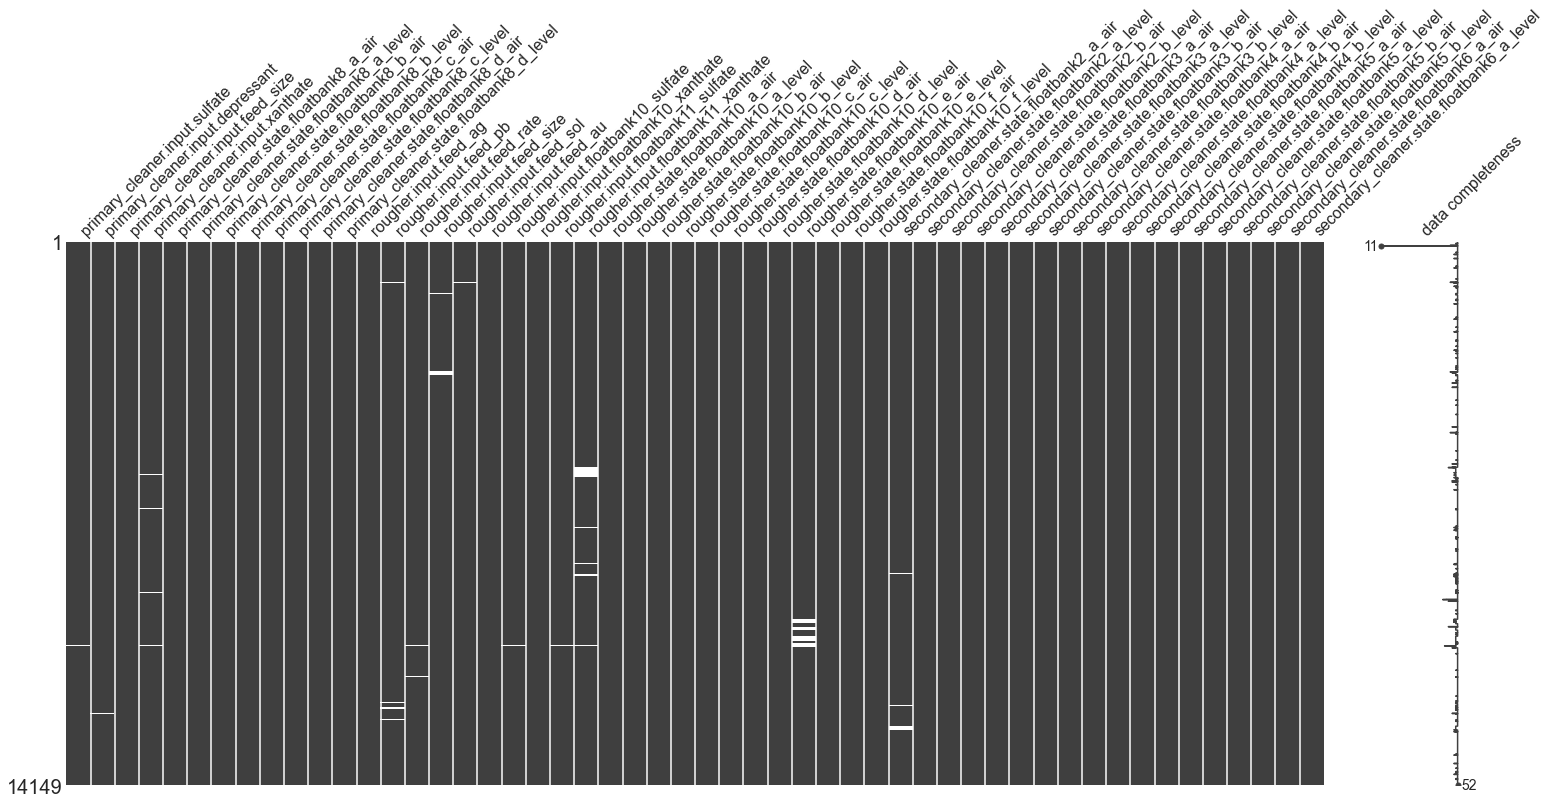

In [11]:
msno.matrix(train_df, labels=True, figsize=(25, 10))
plt.show()

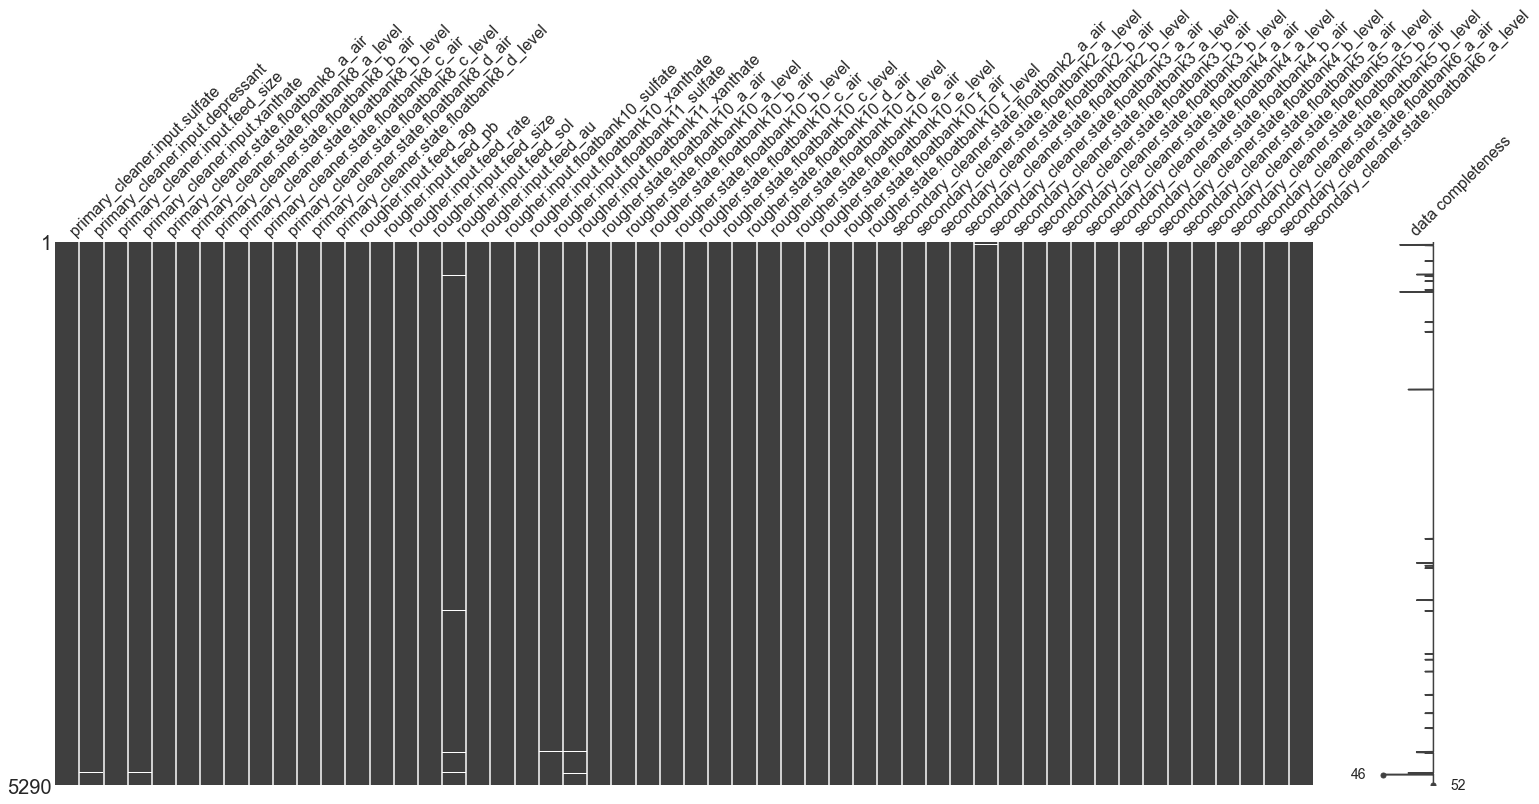

In [12]:
msno.matrix(test_df, labels=True, figsize=(25, 10))
plt.show()

In [13]:
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

print(f'Number of missing values in the train dataset: {train_df.isna().sum().sum()}')
print(f'Number of missing values in the test dataset: {test_df.isna().sum().sum()}')

Number of missing values in the train dataset: 0
Number of missing values in the test dataset: 0


> Пропуски заполнены методом fill forward, так как `Соседние по времени параметры часто похожи.`

#### Проверка на наличие мультиколлинеарных признаков

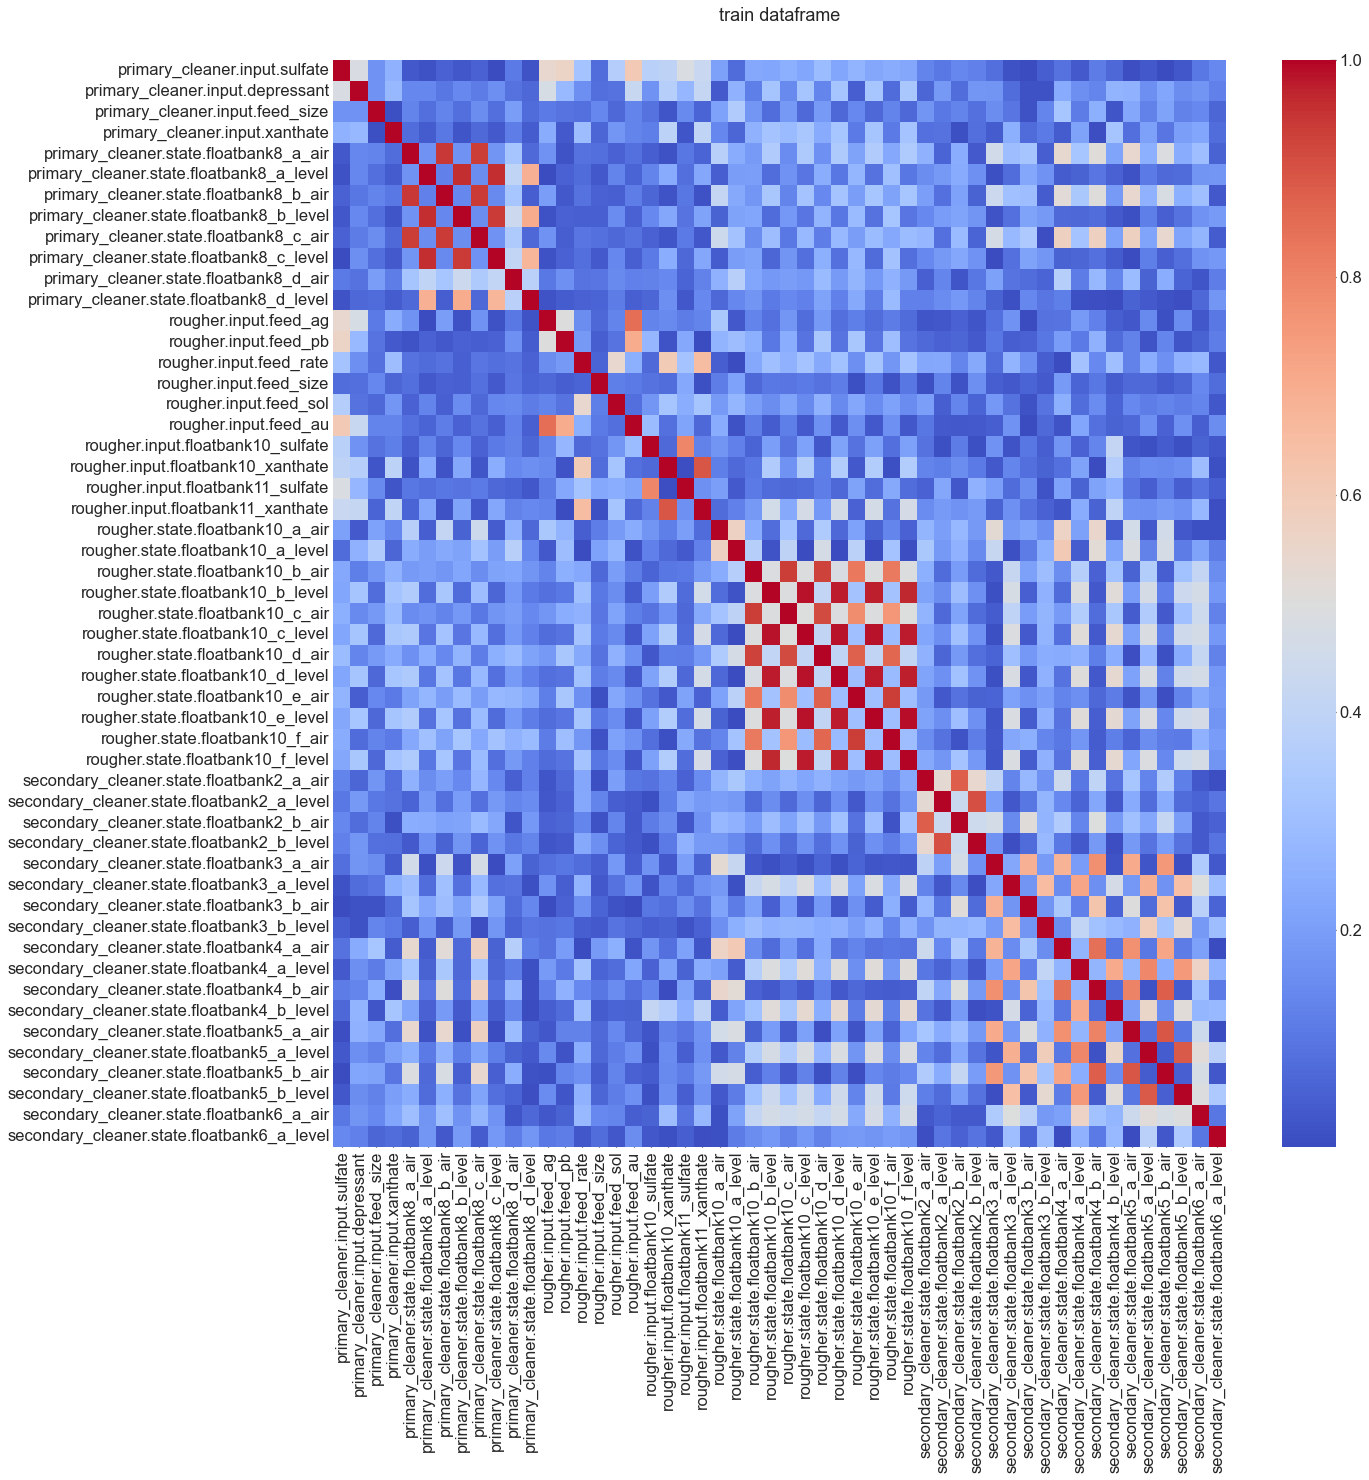

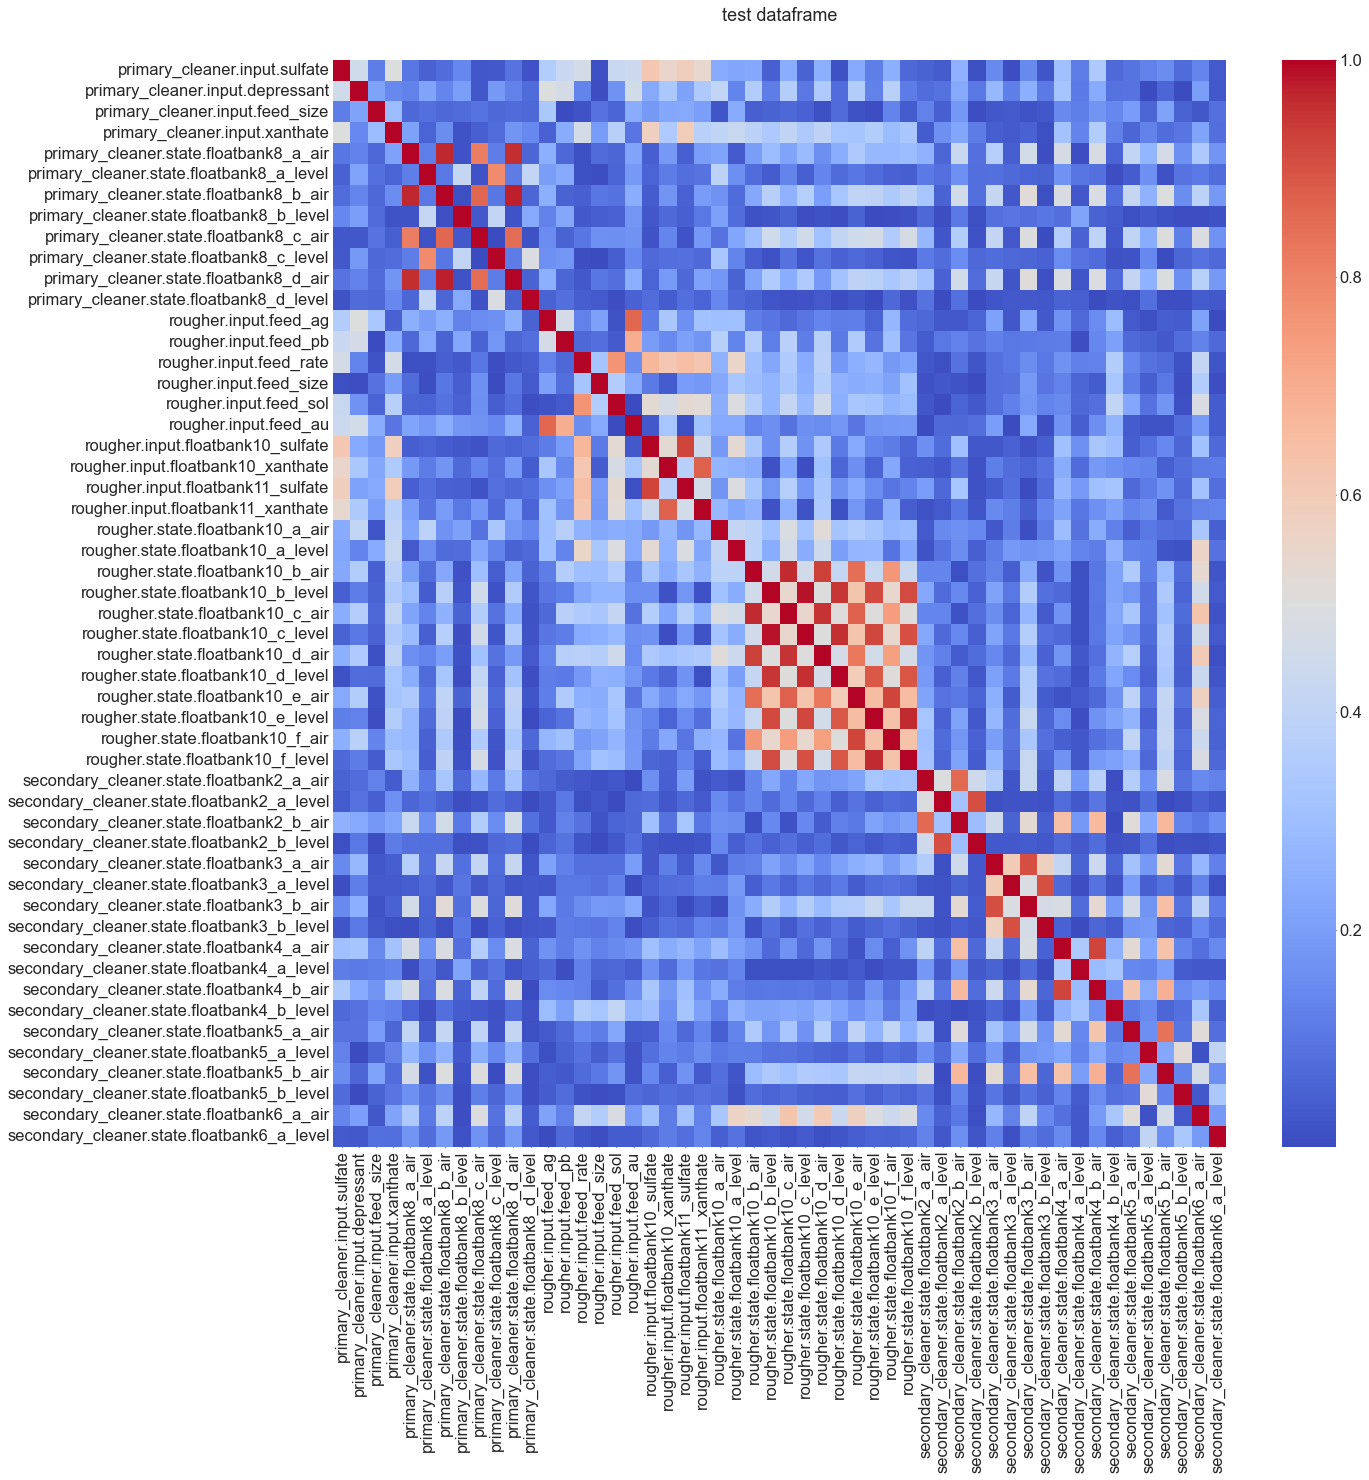

In [14]:
for df, title in zip([train_df, test_df], ['train', 'test']):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax)
    ax.set_title(f'{title} dataframe', y=1.03)

> Подозрительные области наблюдаются в центре и вдоль главной диагонали. Избавлюсь от мультиколлинеарных признаков:

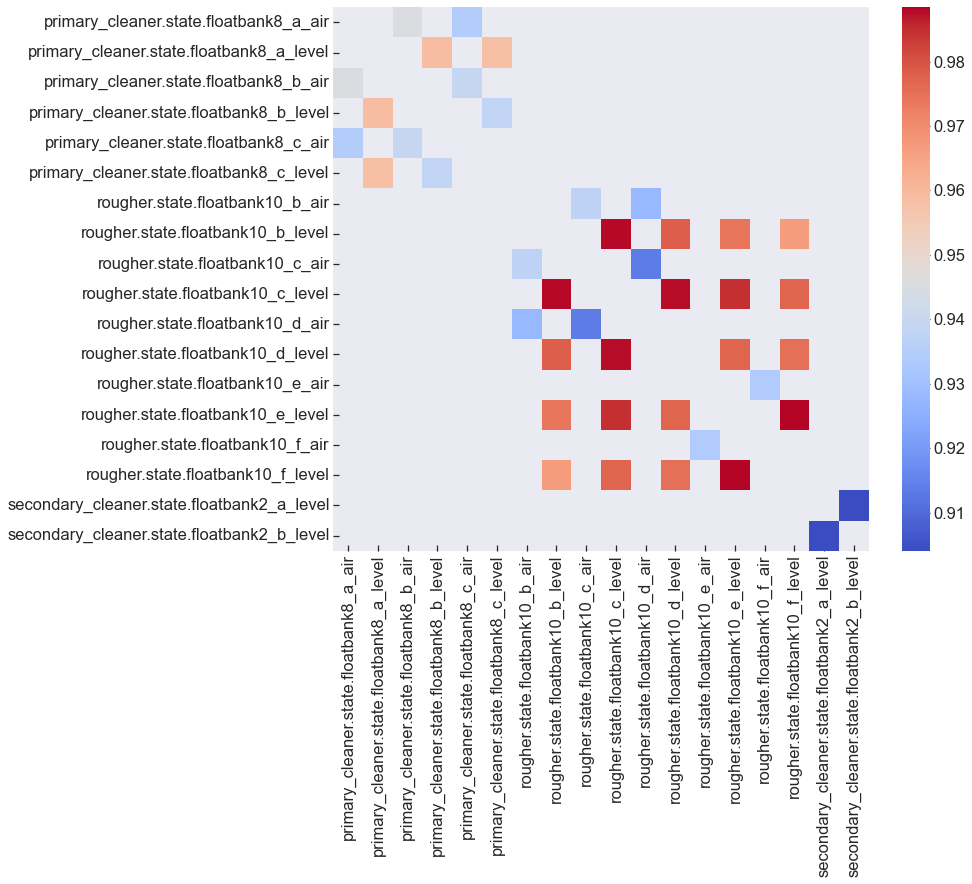

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))

def get_overcorr_matrix(df, threshold=0.9):
    
    """
    Returns the correlation matrix with the absolute values above the threshold
    """

    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Suspiciously high correlations
    overcorr_matrix = corr_matrix[(corr_matrix > threshold) & (corr_matrix < 1)]
    overcorr_matrix = overcorr_matrix.dropna(how='all', axis=0)
    overcorr_matrix = overcorr_matrix.dropna(how='all', axis=1)

    if overcorr_matrix.shape[0] == 0:
        print('No highly correlated features')
        return None

    return overcorr_matrix

train_overcorr_matrix = get_overcorr_matrix(train_df)
sns.heatmap(train_overcorr_matrix, annot=False, cmap='coolwarm', ax=ax, fmt='.2f')

plt.show()

In [16]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, thresh=.9):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr > thresh]

print(f"Top Absolute Correlations")
train_corr_pairs = get_top_abs_correlations(train_df)

train_corr_pairs

Top Absolute Correlations


rougher.state.floatbank10_e_level           rougher.state.floatbank10_f_level             0.988426
rougher.state.floatbank10_b_level           rougher.state.floatbank10_c_level             0.988065
rougher.state.floatbank10_c_level           rougher.state.floatbank10_d_level             0.987670
                                            rougher.state.floatbank10_e_level             0.984585
rougher.state.floatbank10_b_level           rougher.state.floatbank10_d_level             0.978084
rougher.state.floatbank10_c_level           rougher.state.floatbank10_f_level             0.977217
rougher.state.floatbank10_d_level           rougher.state.floatbank10_e_level             0.977010
                                            rougher.state.floatbank10_f_level             0.975010
rougher.state.floatbank10_b_level           rougher.state.floatbank10_e_level             0.973939
                                            rougher.state.floatbank10_f_level             0.966741
primary_cl

<div class="alert alert-block alert-warning">
<b> Комментарий студента</b>
    
Решение взял [отсюда](https://stackoverflow.com/a/41453817/10306817). Думаю, что это изобретение велосипеда, но очевидных решений из коробки не нашел.

</div>

In [17]:
# Check for highly correlated features
train_columns_to_drop = set(train_corr_pairs.index.get_level_values(1))

train_corr_filter_df = train_df.drop(columns=train_columns_to_drop)

get_overcorr_matrix(train_corr_filter_df)

# fig, ax = plt.subplots(figsize=(12, 10))
# sns.heatmap(filtered_train_overcorr_matrix, annot=False, cmap='coolwarm', ax=ax, fmt='.2f')

No highly correlated features


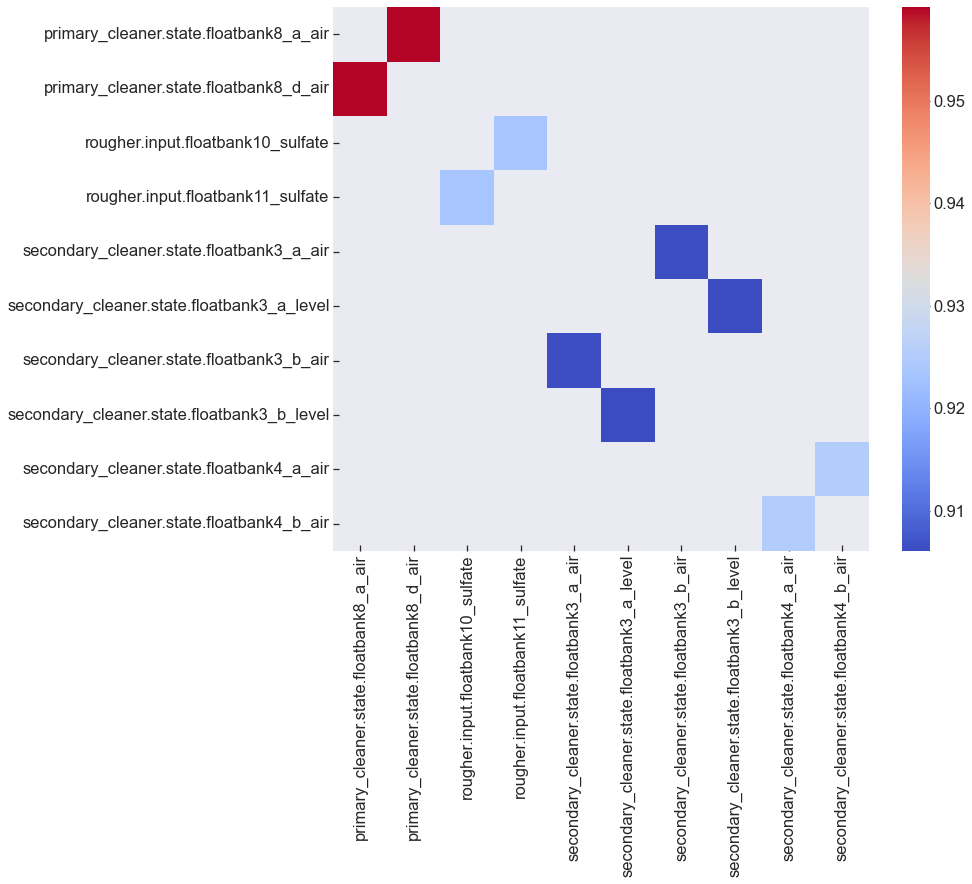

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

test_corr_filter_df = test_df.drop(columns=train_columns_to_drop)

test_filtered_overcorr_matrix = get_overcorr_matrix(test_corr_filter_df)

sns.heatmap(test_filtered_overcorr_matrix, annot=False, cmap='coolwarm', ax=ax, fmt='.2f')

plt.show()

<div class="alert alert-block alert-warning">
<b> Комментарий студента</b>
    
Странно, что в тестовой выборке все равно остаются мультиколлинеарные признаки (даже после вычистки тех, что были найдены в тренировончой выборке). Как с ними лучше поступить не знаю, исключать из рассмотрения не буду.

</div>

## Анализ данных

### Изменение концентрации металлов

In [19]:
def concentrate_hist(df, meatal_name, xmax=50, ndots=100):
    
    '''
    # Replaces zero concentration with previous non-zero value.
    Plots histogram of concentration for a given meatal.
    '''

    # df[f'rougher.input.feed_{meatal_name}'].replace(to_replace=0, method='ffill', inplace=True)
    # df[f'rougher.output.concentrate_{meatal_name}'].replace(to_replace=0, method='ffill', inplace=True)
    # df[f'primary_cleaner.output.concentrate_{meatal_name}'].replace(to_replace=0, method='ffill', inplace=True)
    # df[f'final.output.concentrate_{meatal_name}'].replace(to_replace=0, method='ffill', inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))

    linspace = np.linspace(0, xmax, ndots)

    ax.hist(df[f'rougher.input.feed_{meatal_name}'], alpha=0.5, bins=linspace, label='before floatation')
    input_median = df[f'rougher.input.feed_{meatal_name}'].median()
    ax.axvline(input_median, color='blue', lw=2)

    ax.hist(df[f'rougher.output.concentrate_{meatal_name}'], alpha=0.5, bins=linspace, label='after floatation')
    ax.axvline(df[f'rougher.output.concentrate_{meatal_name}'].median(), color='orange', linestyle='dashed', lw=2)

    ax.hist(df[f'primary_cleaner.output.concentrate_{meatal_name}'], alpha=0.5, bins=linspace, label='after primary cleaner')
    ax.axvline(df[f'primary_cleaner.output.concentrate_{meatal_name}'].median(), color='green', linestyle='-.', lw=2)

    ax.hist(df[f'final.output.concentrate_{meatal_name}'], alpha=0.5, bins=linspace, label='final')
    output_median = df[f'final.output.concentrate_{meatal_name}'].median()
    ax.axvline(output_median, color='red', lw=2)

    ax.legend(bbox_to_anchor=(1.01, .6), loc="upper left")
    ax.set_xlabel(f'{meatal_name} concentration')

    print(f'concentration gain: {output_median / input_median:.2f}')

    plt.show()

concentration gain: 5.54


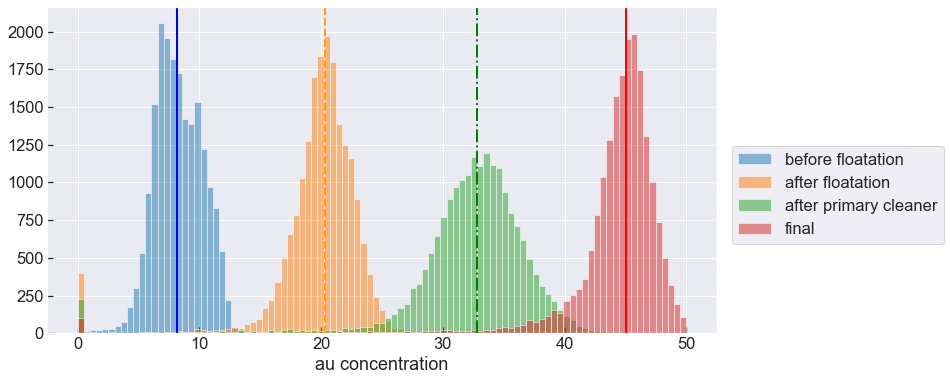

In [20]:
concentrate_hist(full_df, 'au')

concentration gain: 0.59


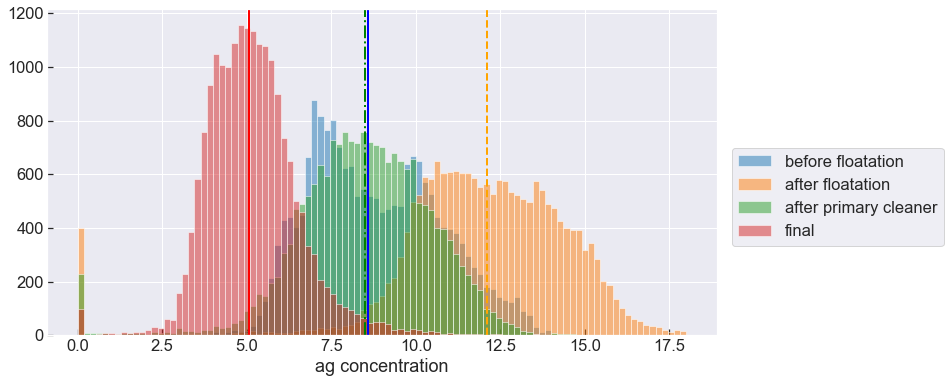

In [21]:
concentrate_hist(full_df, 'ag', xmax=18, ndots=100)

concentration gain: 2.86


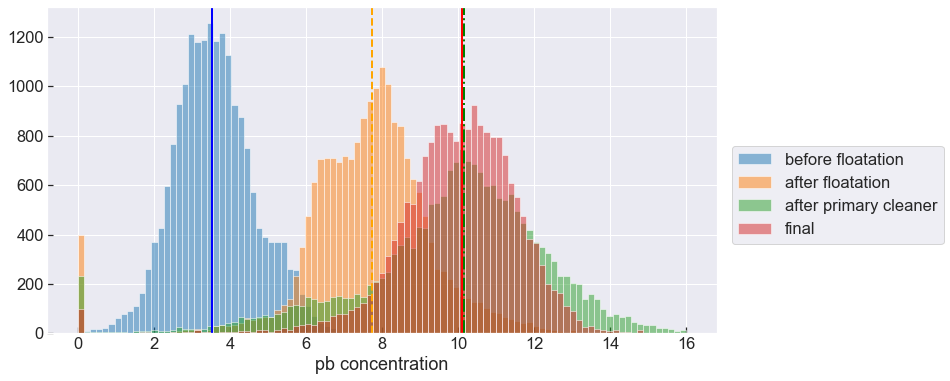

In [22]:
concentrate_hist(full_df, 'pb', xmax=16, ndots=100)

> Концентрация золота последовательно увеличивается на каждом этапе очистки (медианное значение возрастает в ~5.5 раз)

> Концентрация серебра возрастает после флотации, но падает на финальном этапе (в медианное значение сокращается на 40%)

> Свинец отделяется хуже серебра, медианное значение его концентрации возрастает в 2.9 раз после очистки

### Размеры гранул сырья 

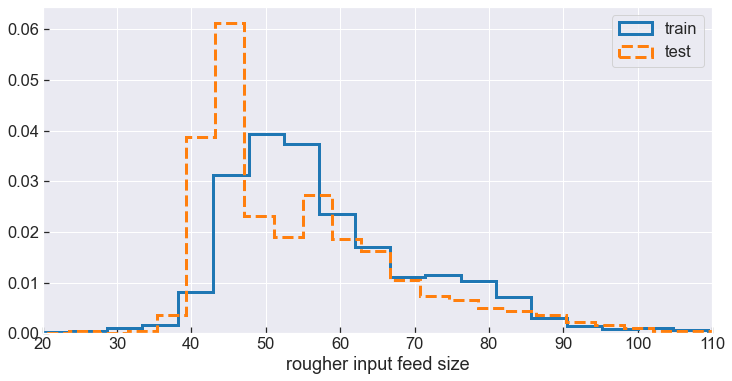

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(train_corr_filter_df['rougher.input.feed_size'], bins=100, density=True,
histtype='step', lw=3, label='train')

ax.hist(test_corr_filter_df['rougher.input.feed_size'], bins=100, density=True,
histtype='step', lw=3, ls='dashed', label='test')

ax.set_xlabel('rougher input feed size')
ax.legend()

ax.set_xlim(20, 110)

plt.show()

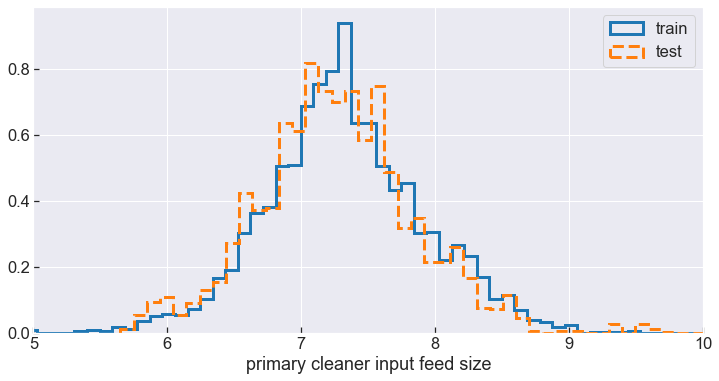

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(5, 10)

ax.hist(train_corr_filter_df['primary_cleaner.input.feed_size'], bins=100, density=True,
histtype='step', lw=3, label='train')

ax.hist(test_corr_filter_df['primary_cleaner.input.feed_size'], bins=100, density=True,
histtype='step', lw=3, ls='dashed', label='test')

ax.set_xlabel('primary cleaner input feed size')
ax.legend()

ax.set_xlim(5, 10)

plt.show()

> Различия между распределениями небольшие в обоих случаях, но для исходного сырья более заметны

### Суммарная концентрация всех веществ на разных стадиях

In [25]:
features_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]
features_rough_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]
features_final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
]

# bad indexes
zero_concent_idxs = full_df[full_df[features_input_concentrate].sum(1) == 0].index
zero_concent_idxs = zero_concent_idxs.union(full_df[full_df[features_rough_concentrate].sum(1) == 0].index)
zero_concent_idxs = zero_concent_idxs.union(full_df[full_df[features_final_concentrate].sum(1) == 0].index)

# dublicates check
zero_concent_idxs = zero_concent_idxs.drop_duplicates()

# exclude bad indexes
train_corr_conc_df = train_corr_filter_df[~train_corr_filter_df.index.isin(zero_concent_idxs)]
test_corr_conc_df = test_corr_filter_df[~test_corr_filter_df.index.isin(zero_concent_idxs)]

print('Data loss due to zero concentration:')
print()
print(f'{1 - train_corr_conc_df.shape[0] / train_corr_filter_df.shape[0]:.0%} of train data')
print(f'{1 - test_corr_conc_df.shape[0] / test_corr_filter_df.shape[0]:.0%} of test data')

> В распределении суммарной концентрации веществ присутствовали аномальные значения (нулевые)

> Объекты с нулевой суммарной концентрацией были исключены из тестовой и из тренировочной выборки

## Модель

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке